In [1]:
# ----------------------
# Load required packages
# ----------------------

import gc
import sys, getopt
import ujson as json
import random
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 

# -----------------------
# Handle script arguments
# -----------------------

filename = 'BE_WAVE1_R0_COMP_EFF_2021-05-15.json'
n_samples = 10
n_draws_per_sample = 1

# --------------------------
# Define simulation settings
# --------------------------

# Start and end of simulation
start_sim = '2020-03-10'
end_sim = '2020-09-03'
# Confidence level used to visualise model fit
conf_int = 0.05
# Path where figures and results should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/others/WAVE1/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

# -----------------------
# Load samples dictionary
# -----------------------

from covid19model.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+str(filename), wave=1)
warmup = int(samples_dict['warmup'])

# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Sciensano public data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Sciensano mortality data
df_sciensano_mortality =sciensano.get_mortality_data()
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
# Start of data collection
start_data = df_sciensano.idxmin()
# Start of calibration warmup and beta
start_calibration = samples_dict['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict['end_calibration']

# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, ramp_fun
policies_WAVE1 = make_contact_matrix_function(df_google, Nc_all).policies_WAVE1

# ---------------------------------------------------
# Function to add poisson draws and sampling function
# ---------------------------------------------------

from covid19model.models.utils import output_to_visuals, draw_fcn_WAVE1

# --------------------
# Initialize the model
# --------------------

# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(VOC=False)
# Add the time-dependant parameter function arguments
params.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5, 'prev_home': 0.5})
# Define initial states
initial_states = {"S": initN, "E": np.ones(9), "I": np.ones(9)}
# Initialize model
model = models.COVID19_SEIRD(initial_states, params,
                        time_dependent_parameters={'Nc': policies_WAVE1})

In [19]:
# ------------------------------
# Define the evaluation function
# ------------------------------
from covid19model.optimization import objective_fcns

def evaluate_model(thetas, names, model, data, states, warmup, start_date, draw_fcn, samples):
    thetas = list(thetas)
    thetas[2] = adjust_a(thetas[2]) # rescale a from population average to age-stratified
    thetas[4] = adjust_h(thetas[4]) # rescale h from population average to age-stratified
    return objective_fcns.MLE(thetas, model, data, states, names, warmup=warmup, start_date=start_date,
                              draw_fcn=draw_fcn, samples=samples, poisson_offset=1)
    
# ------------------------
# Define the draw function
# ------------------------

def draw_fcn(param_dict,samples_dict):
    param_dict['sigma'] = 5.2 - param_dict['omega']
    return param_dict 

# ---------------
# Define the data
# ---------------

data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = ["H_in"]

# -------------------------------------
# Define an update function for a and h
# -------------------------------------

# What if we'd do something similar during the model calibration? Keep the ratios of a and h between the
# different ages the same and allow the calibration to scale the parameters?

def adjust_h(overall_h):
    virgin_h = np.array([0.015,0.02,0.03,0.03,0.03,0.06,0.15,0.35,0.8])
    return virgin_h*(overall_h/0.115)

def adjust_a(overall_a):
    virgin_a = np.array([0.9839006419392712, 0.9778633826664977, 0.875229975029351,0.694112196846151, 0.5874539496938209, 0.390236813449893,0.12862224496304697, 0.06824965223531398, 0.008923517781529])
    return virgin_a*(overall_a/0.57)

In [23]:
# ------------------
# Define the problem
# ------------------

problem = {
    'num_vars': 10,
    'names': ['beta', 'omega', 'a', 'da', 'h', 'zeta', 'l', 'prev_work', 'prev_rest', 'prev_home'],
    'bounds': [[0.02, 0.08],
               [0.1, 5],
               [0.10, 0.57],
               [1, 14],
               [0.02, 0.14],
               [0.000925,0.1075], # 3 years - 3 months
               [0.1, 14],
               [0.01,0.99],
               [0.01,0.99],
               [0.01,0.99]]
}

In [24]:
from SALib.plotting.bar import plot as barplot

In [29]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# ----------------
# Perform sampling
# ----------------

param_values = saltelli.sample(problem, 100)
print(param_values.shape)
# --------------
# Evaluate model
# --------------

Y = np.zeros([param_values.shape[0]])
for i, thetas in enumerate(param_values):
    Y[i] = evaluate_model(thetas, problem['names'], model, data, states, warmup, start_calibration, draw_fcn, {})
    
# ---------------------
# Compute sobol weights
# ---------------------

Si = sobol.analyze(problem, Y)
total_Si, first_Si, second_Si = Si.to_df()

(2200, 10)


<AxesSubplot:>

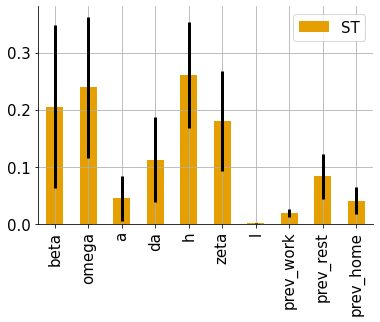

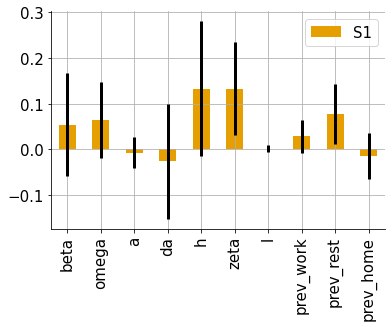

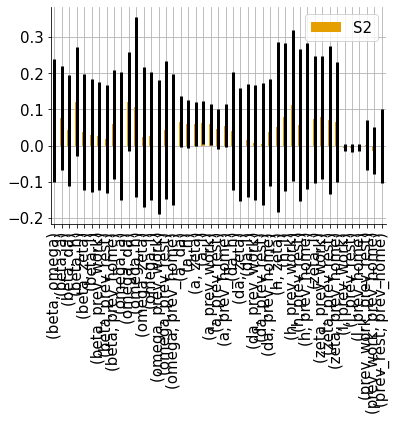

In [30]:
# -----------------------
# Visualize sobol weights
# -----------------------

barplot(total_Si)

barplot(first_Si)

barplot(second_Si)